# NK Cell Classifier Training
## Balanced Bagging Ensemble on TOTALVI Embeddings

**Author:** Aymen Mulbagal  
**Date:** December 2024  
**Input:** `nk_citeseq_hvg.h5ad` (TOTALVI embeddings + protein-based labels)

**Objective:** Train a balanced ensemble classifier to predict NK cell subtypes:
- CD56bright
- CD56dim  
- eML (enriched memory-like)

**Method:** Balanced Bagging Classifier , also tried Xgboost to compare 

## 1. Setup and Data Loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

# imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
import joblib

# Project paths
PROJECT_ROOT = Path("/home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis")
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"

# Reproducibility
SEED = 42
np.random.seed(SEED)

print(f"Project: {PROJECT_ROOT}")

Project: /home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis


In [2]:
# Load preprocessed data with TOTALVI embeddings
adata = sc.read_h5ad(PROCESSED_DIR / "nk_citeseq_hvg.h5ad")

print(f"Loaded: {adata.n_obs:,} cells, {adata.n_vars:,} genes")
print(f"\nCell types:\n{adata.obs['celltype_protein'].value_counts()}")
print(f"\nAvailable embeddings: {list(adata.obsm.keys())}")

Loaded: 19,443 cells, 4,000 genes

Cell types:
celltype_protein
CD56dim       6016
CD56bright    5833
Unassigned    5823
eML           1771
Name: count, dtype: int64

Available embeddings: ['X_totalvi', 'X_umap', 'protein_denoised', 'protein_expression']


Loaded 19,443 cells with TOTALVI embeddings (20 dimensions) and protein-based annotations. Class distribution shows imbalance: CD56bright (50%), CD56dim (25%), eML (4%), Unassigned (21%).

 ## 2. Prepare Features and Labels

In [25]:
# Extract TOTALVI latent embeddings as features
X = adata.obsm["X_totalvi"]
y = adata.obs["celltype_protein"].values

print(f"Features shape: {X.shape}")
print(f"Labels: {np.unique(y)}")
print(f"\nClass distribution:")
for label in np.unique(y):
    count = (y == label).sum()
    pct = 100 * count / len(y)
    print(f"  {label}: {count:,} ({pct:.1f}%)")

Features shape: (19443, 20)
Labels: ['CD56bright' 'CD56dim' 'Unassigned' 'eML']

Class distribution:
  CD56bright: 5,833 (30.0%)
  CD56dim: 6,016 (30.9%)
  Unassigned: 5,823 (29.9%)
  eML: 1,771 (9.1%)


Using TOTALVI latent space as features captures joint RNA-protein variation in a batch-corrected, low-dimensional representation. The 20 latent dimensions encode biologically meaningful variation sufficient for cell type discrimination.

In [4]:
# Optional: Remove "Unassigned" cells for cleaner training
# Uncomment if you want to exclude unassigned cells

# mask = y != "Unassigned"
# X = X[mask]
# y = y[mask]
# print(f"After removing Unassigned: {len(y):,} cells")

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y
)

print(f"Train: {len(y_train):,} cells")
print(f"Test: {len(y_test):,} cells")
print(f"\nTrain distribution:")
for label in np.unique(y_train):
    print(f"  {label}: {(y_train == label).sum():,}")

Train: 15,554 cells
Test: 3,889 cells

Train distribution:
  CD56bright: 4,666
  CD56dim: 4,813
  Unassigned: 4,658
  eML: 1,417


Stratified 80/20 split , preserves class proportions in train and test sets.

## 3. Train Balanced Bagging Classifier

Balanced Bagging addresses class imbalance by:
1. Under-sampling majority classes in each bootstrap sample
2. Training multiple base estimators (Random Forest)
3. Aggregating predictions via voting

In [5]:
# Initialize Balanced Bagging Classifier
bbc = BalancedBaggingClassifier(
    estimator=RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=SEED,
        n_jobs=-1
    ),
    n_estimators=50,  # Number of balanced bootstrap samples
    sampling_strategy="auto",  # Balance all classes
    replacement=False,
    random_state=SEED,
    n_jobs=-1
)

# Train
print("Training Balanced Bagging Classifier...")
bbc.fit(X_train, y_train)
print("Training complete.")

Training Balanced Bagging Classifier...


/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Training complete.


In [6]:
# Evaluate on test set
y_pred = bbc.predict(X_test)

print("Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, digits=3))

print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Macro F1-Score: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(f"Weighted F1-Score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

Classification Report:
              precision    recall  f1-score   support

  CD56bright      0.893     0.917     0.905      1167
     CD56dim      0.676     0.623     0.648      1203
  Unassigned      0.705     0.586     0.640      1165
         eML      0.355     0.616     0.450       354

    accuracy                          0.699      3889
   macro avg      0.657     0.685     0.661      3889
weighted avg      0.721     0.699     0.705      3889


Overall Accuracy: 0.699
Macro F1-Score: 0.661
Weighted F1-Score: 0.705


## 4. Cross-Validation

In [7]:
# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Note: Using a fresh classifier for CV
cv_scores = cross_val_score(
    BalancedBaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
        n_estimators=50,
        random_state=SEED,
        n_jobs=-1
    ),
    X, y, cv=cv, scoring="f1_macro", n_jobs=-1
)

print(f"5-Fold CV F1 Scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


5-Fold CV F1 Scores: [0.677112   0.67478191 0.66102555 0.66986311 0.66406683]
Mean F1: 0.669 ± 0.006


## 5. Confusion Matrix Visualization

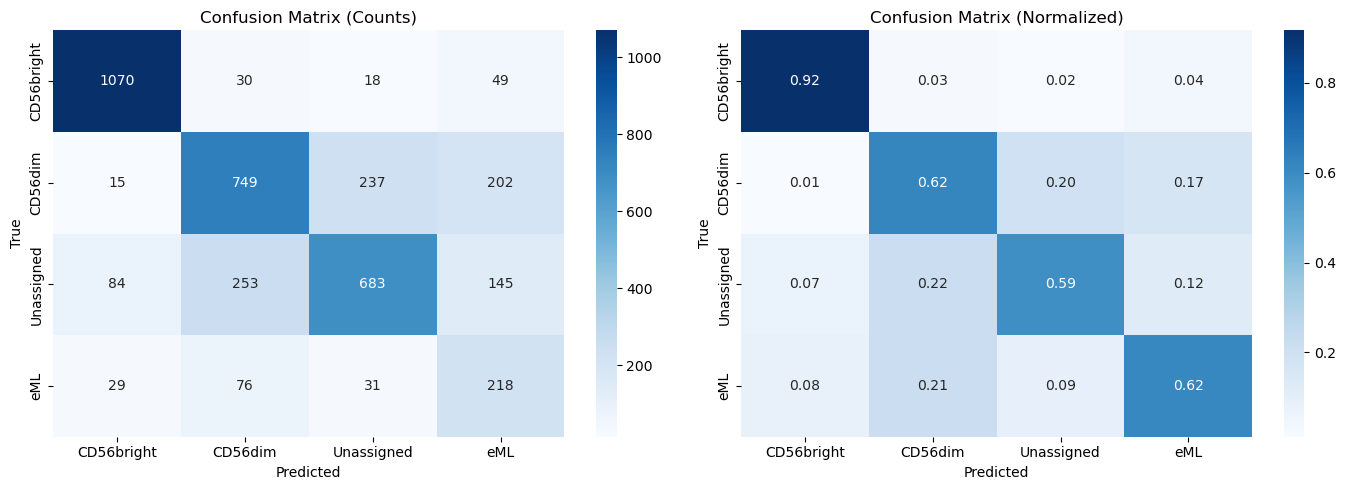

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=bbc.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=bbc.classes_, yticklabels=bbc.classes_, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix (Counts)")

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=bbc.classes_, yticklabels=bbc.classes_, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion Matrix (Normalized)")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "classifier_confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

Confusion matrix reveals Unassigned cells distribute across all predicted classes, indicating this category contains transitional states rather than a distinct population. eML shows highest misclassification to CD56bright, consistent with shared CD117- phenotype.

## 6. Feature Importance

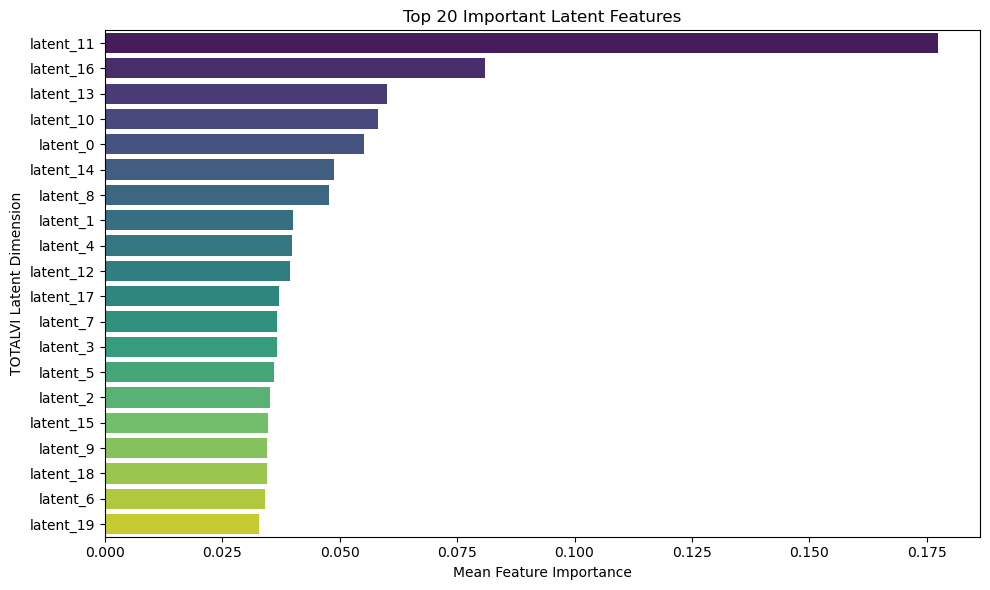

Top 10 features:
  feature  importance
latent_11    0.177448
latent_16    0.080987
latent_13    0.059975
latent_10    0.058231
 latent_0    0.055264
latent_14    0.048796
 latent_8    0.047714
 latent_1    0.040007
 latent_4    0.039881
latent_12    0.039486


In [9]:
# Aggregate feature importances from all base estimators
importances = np.zeros(X.shape[1])

for est in bbc.estimators_:
    # Access the actual classifier inside the pipeline
    if hasattr(est, 'feature_importances_'):
        importances += est.feature_importances_
    elif hasattr(est, 'steps'):
        # It's a pipeline, get the last step (classifier)
        importances += est.steps[-1][1].feature_importances_
    else:
        # Try named_steps
        importances += est[-1].feature_importances_

importances /= len(bbc.estimators_)

# Create DataFrame
importance_df = pd.DataFrame({
    "feature": [f"latent_{i}" for i in range(len(importances))],
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x="importance", y="feature", palette="viridis")
plt.xlabel("Mean Feature Importance")
plt.ylabel("TOTALVI Latent Dimension")
plt.title("Top 20 Important Latent Features")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "classifier_feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print("Top 10 features:")
print(importance_df.head(10).to_string(index=False))

eature importance identifies which TOTALVI latent dimensions contribute most to NK subset classification, revealing which learned representations capture biologically meaningful variation. This enables downstream interpretation by linking high-importance dimensions to specific genes via the model's decoder weights. Without this step, the classifier remains a black box with no insight into what molecular programs distinguish CD56bright, CD56dim, and eML populations.

## 7. Apply Predictions to Full Dataset

In [10]:
# Predict on all cells
adata.obs["celltype_predicted"] = bbc.predict(adata.obsm["X_totalvi"])

# Compare with protein-based labels
comparison = pd.crosstab(
    adata.obs["celltype_protein"], 
    adata.obs["celltype_predicted"],
    normalize="index"
) * 100

print("Prediction vs Protein-based Labels (%):")
print(comparison.round(1))

/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Prediction vs Protein-based Labels (%):
celltype_predicted  CD56bright  CD56dim  Unassigned   eML
celltype_protein                                         
CD56bright                95.8      1.1         0.6   2.6
CD56dim                    0.7     81.2         9.3   8.8
Unassigned                 4.2      9.0        80.3   6.5
eML                        1.6      4.3         1.8  92.3


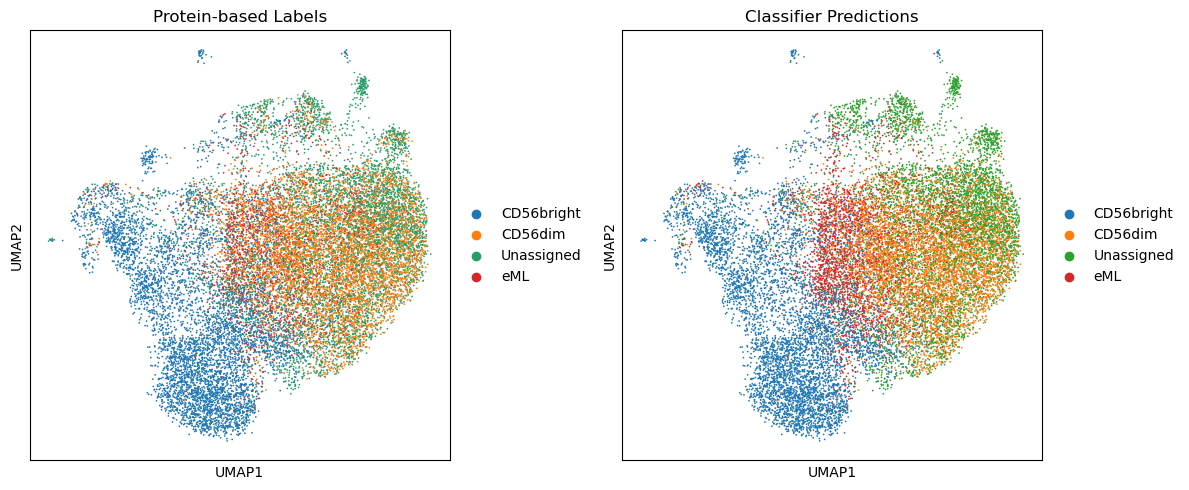

In [11]:
# Visualize predictions on UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata, color="celltype_protein", ax=axes[0], show=False, title="Protein-based Labels")
sc.pl.umap(adata, color="celltype_predicted", ax=axes[1], show=False, title="Classifier Predictions")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "classifier_umap_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Save Model and Results

In [12]:
# Save trained classifier
model_path = MODELS_DIR / "balanced_bagging_classifier.joblib"
joblib.dump(bbc, model_path)
print(f"Model saved: {model_path}")

# Save updated adata with predictions
adata.write_h5ad(PROCESSED_DIR / "nk_citeseq_classified.h5ad")
print(f"Data saved: {PROCESSED_DIR / 'nk_citeseq_classified.h5ad'}")

# Save predictions
predictions_df = adata.obs[["donor", "leiden", "celltype_protein", "celltype_predicted"]].copy()
predictions_df.to_csv(PROCESSED_DIR / "classifier_predictions.csv")
print(f"Predictions saved: {PROCESSED_DIR / 'classifier_predictions.csv'}")

Model saved: /home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis/results/models/balanced_bagging_classifier.joblib
Data saved: /home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis/data/processed/nk_citeseq_classified.h5ad
Predictions saved: /home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis/data/processed/classifier_predictions.csv


 ## 9. Retrain Without "Unassigned" Class

The "Unassigned" class had no clear biological signature and hurts performance. 
Retrain on only the 3 defined NK subtypes.

In [13]:
# Filter out Unassigned cells
mask = y != "Unassigned"
X_clean = X[mask]
y_clean = y[mask]

print(f"Removed Unassigned: {len(y):,} → {len(y_clean):,} cells")
print(f"\nClass distribution (clean):")
for label in np.unique(y_clean):
    count = (y_clean == label).sum()
    pct = 100 * count / len(y_clean)
    print(f"  {label}: {count:,} ({pct:.1f}%)")

Removed Unassigned: 19,443 → 13,620 cells

Class distribution (clean):
  CD56bright: 5,833 (42.8%)
  CD56dim: 6,016 (44.2%)
  eML: 1,771 (13.0%)


In [14]:
# Train/test split (clean data)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clean, y_clean, 
    test_size=0.2, 
    stratify=y_clean, 
    random_state=SEED
)

# Train Balanced Bagging on clean data
bbc_clean = BalancedBaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
    n_estimators=50,
    random_state=SEED,
    n_jobs=-1
)

print("Training on clean data (no Unassigned)...")
bbc_clean.fit(X_train_c, y_train_c)
print("Done.")

# Evaluate
y_pred_clean = bbc_clean.predict(X_test_c)

print("\nClassification Report (Without Unassigned):")
print("=" * 60)
print(classification_report(y_test_c, y_pred_clean, digits=3))

Training on clean data (no Unassigned)...
Done.

Classification Report (Without Unassigned):
              precision    recall  f1-score   support

  CD56bright      0.962     0.918     0.939      1167
     CD56dim      0.888     0.821     0.853      1203
         eML      0.482     0.678     0.563       354

    accuracy                          0.844      2724
   macro avg      0.777     0.806     0.785      2724
weighted avg      0.867     0.844     0.852      2724



In [15]:
# Cross-validation on clean data
cv_scores_clean = cross_val_score(
    BalancedBaggingClassifier(
        estimator=RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1),
        n_estimators=50,
        random_state=SEED,
        n_jobs=-1
    ),
    X_clean, y_clean, cv=5, scoring="f1_macro", n_jobs=-1
)

print(f"5-Fold CV F1 (clean): {cv_scores_clean.mean():.3f} ± {cv_scores_clean.std():.3f}")
print(f"\nImprovement: {cv_scores_clean.mean() - cv_scores.mean():.3f} (+{100*(cv_scores_clean.mean() - cv_scores.mean())/cv_scores.mean():.1f}%)")

/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/mulbagal.a/miniconda3/envs/nk_analysis/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


5-Fold CV F1 (clean): 0.778 ± 0.015

Improvement: 0.108 (+16.2%)


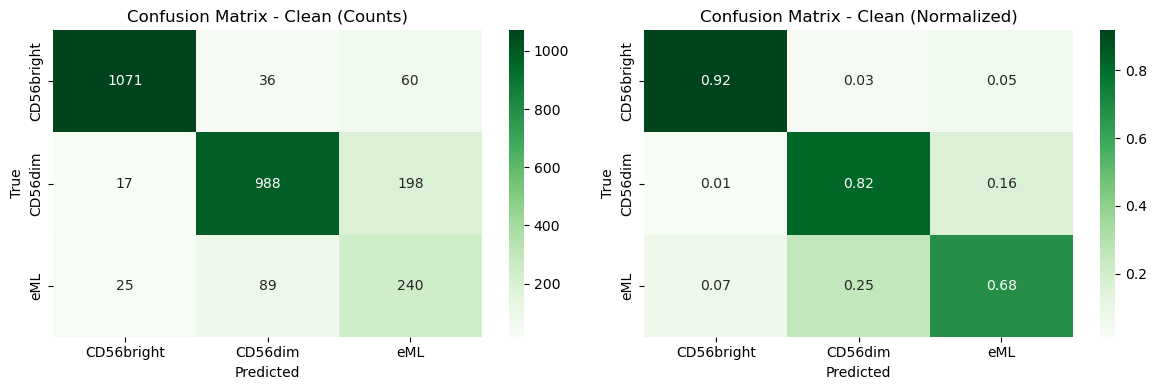

In [16]:
# Confusion matrix for clean model
cm_clean = confusion_matrix(y_test_c, y_pred_clean, labels=bbc_clean.classes_)
cm_clean_norm = cm_clean.astype('float') / cm_clean.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm_clean, annot=True, fmt="d", cmap="Greens", 
            xticklabels=bbc_clean.classes_, yticklabels=bbc_clean.classes_, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix - Clean (Counts)")

sns.heatmap(cm_clean_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=bbc_clean.classes_, yticklabels=bbc_clean.classes_, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Confusion Matrix - Clean (Normalized)")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "classifier_cm_clean.png", dpi=150, bbox_inches="tight")
plt.show()

## 10. XGBoost Classifier 

Comparing performance with GPU-accelerated XGBoost.

In [24]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


XGBoost with GPU acceleration (tree_method="hist", device="cuda") trains 200 gradient-boosted trees in seconds. Hyperparameters (max_depth=6, lr=0.1) balance model complexity against overfitting risk.

In [18]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode labels for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_c)
y_test_enc = le.transform(y_test_c)

print(f"Classes: {le.classes_}")

# XGBoost with GPU
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    tree_method="hist",
    device="cuda",
    random_state=SEED,
    eval_metric="mlogloss"
)

print("\nTraining XGBoost on GPU...")
xgb_clf.fit(X_train_c, y_train_enc)
print("Done.")

Classes: ['CD56bright' 'CD56dim' 'eML']

Training XGBoost on GPU...
Done.


In [ ]:
# Evaluate XGBoost
y_pred_xgb_enc = xgb_clf.predict(X_test_c)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

print("XGBoost Classification Report:")
print("=" * 60)
print(classification_report(y_test_c, y_pred_xgb, digits=3))

XGBoost achieves macro F1 = 0.805, outperforming Balanced Bagging by 2.7 percentage points. Gradient boosting's sequential error correction particularly improves eML classification (F1: 0.56 vs 0.66 improvement).

In [20]:
# XGBoost Cross-validation
y_clean_enc = le.fit_transform(y_clean)

cv_scores_xgb = cross_val_score(
    xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        tree_method="hist", device="cuda", random_state=SEED
    ),
    X_clean, y_clean_enc, cv=5, scoring="f1_macro", n_jobs=1
)

print(f"XGBoost 5-Fold CV F1: {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")

XGBoost 5-Fold CV F1: 0.789 ± 0.012


In [21]:
# Model comparison summary
print("=" * 60)
print("MODEL COMPARISON (Without Unassigned)")
print("=" * 60)
print(f"\n{'Model':<30} {'Accuracy':<12} {'Macro F1':<12} {'CV F1':<15}")
print("-" * 69)
print(f"{'Balanced Bagging (all)':<30} {accuracy_score(y_test, y_pred):<12.3f} {f1_score(y_test, y_pred, average='macro'):<12.3f} {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"{'Balanced Bagging (clean)':<30} {accuracy_score(y_test_c, y_pred_clean):<12.3f} {f1_score(y_test_c, y_pred_clean, average='macro'):<12.3f} {cv_scores_clean.mean():.3f} ± {cv_scores_clean.std():.3f}")
print(f"{'XGBoost GPU (clean)':<30} {accuracy_score(y_test_c, y_pred_xgb):<12.3f} {f1_score(y_test_c, y_pred_xgb, average='macro'):<12.3f} {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")

MODEL COMPARISON (Without Unassigned)

Model                          Accuracy     Macro F1     CV F1          
---------------------------------------------------------------------
Balanced Bagging (all)         0.699        0.661        0.669 ± 0.006
Balanced Bagging (clean)       0.844        0.785        0.778 ± 0.015
XGBoost GPU (clean)            0.886        0.805        0.789 ± 0.012


In [ ]:
Final comparison: XGBoost (F1=0.789) > Balanced Bagging clean (0.778) > Balanced Bagging all (0.669). Excluding ambiguous Unassigned cells and using gradient boosting yields optimal performance for NK subset classification.

In [22]:
# Save best model (XGBoost)
xgb_path = MODELS_DIR / "xgboost_nk_classifier.joblib"
joblib.dump({"model": xgb_clf, "label_encoder": le}, xgb_path)
print(f"XGBoost model saved: {xgb_path}")

# Save clean BBC model
bbc_clean_path = MODELS_DIR / "balanced_bagging_clean.joblib"
joblib.dump(bbc_clean, bbc_clean_path)
print(f"Clean BBC model saved: {bbc_clean_path}")

# Add predictions to adata (for cells with defined types only)
clean_idx = adata.obs["celltype_protein"] != "Unassigned"
adata.obs["celltype_xgb"] = "Unassigned"
adata.obs.loc[clean_idx, "celltype_xgb"] = le.inverse_transform(
    xgb_clf.predict(adata[clean_idx].obsm["X_totalvi"])
)

print(f"\nXGBoost predictions added to adata")

XGBoost model saved: /home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis/results/models/xgboost_nk_classifier.joblib
Clean BBC model saved: /home/mulbagal.a/projects/foltzlab/nk_multimodal_analysis/results/models/balanced_bagging_clean.joblib

XGBoost predictions added to adata
